Omid Jafaei
401204268

In [ ]:
import torch
from torch import nn
import torchvision
from torch.optim import Adam
from torchvision.transforms import Compose, ToTensor, CenterCrop
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
torch.manual_seed(99)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
transform = Compose([
    ToTensor(),
    CenterCrop(size=64)
])

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ['airplane', 'automobile']

def get_index(dataset, classes):
    indices = []
    for i, label in enumerate(dataset.targets):
        if dataset.classes[label] in classes:
            indices.append(i)
    return indices

train_indices =  get_index(full_train_dataset, classes)
test_indices =  get_index(full_test_dataset, classes)

train_dataset = torch.utils.data.Subset(full_train_dataset, train_indices)
test_dataset = torch.utils.data.Subset(full_test_dataset, test_indices)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=10000)

100%|██████████| 170498071/170498071 [00:04<00:00, 38632338.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


##Cross Entropy Loss

قسمت آ

In [ ]:
model1 = torchvision.models.alexnet(pretrained = True)

for param in model1.parameters():
    param.requires_grad = False

n_feaures = model1.classifier[6].in_features
model1.classifier[6] = nn.Linear(in_features = n_feaures, out_features = 2)
#nn.init.xavier_normal_(model1.classifier[6].weight)
#nn.init.zeros_(model1.classifier[6].bias)
model1 = model1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model1.parameters(), lr = 1e-4)


epochs = 50
loss_list = []
acc_list = []
for e in range(epochs):
    batch_loss = []
    batch_acc = []
    model1.train()
    with tqdm(train_dataloader, desc=f'Epoch {e}/{epochs}', unit='batch', leave=False) as epoch_progress:
        for t, (x, y) in enumerate(epoch_progress):
            x, y = x.to(device), y.to(device)
            y_pred = model1(x)
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss)
            _ , preds = torch.max(y_pred, 1)
            correct_counts = preds.eq(y.view_as(preds))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            batch_acc.append(acc)
        loss_list.append(float(sum(batch_loss)/len(batch_loss)))
        acc_list.append(float(sum(batch_acc)/len(batch_acc)))


Text(0.5, 1.0, 'Loss in Different Epochs')

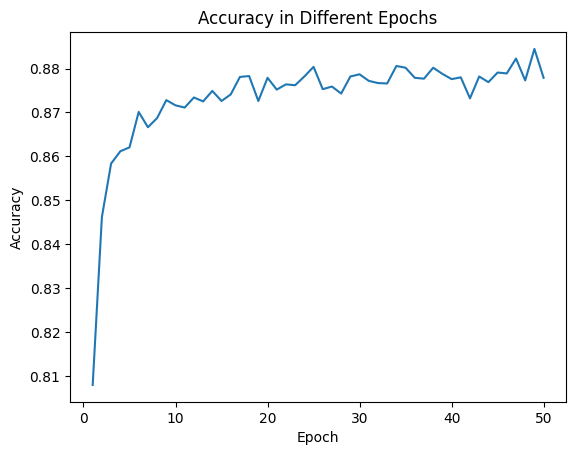

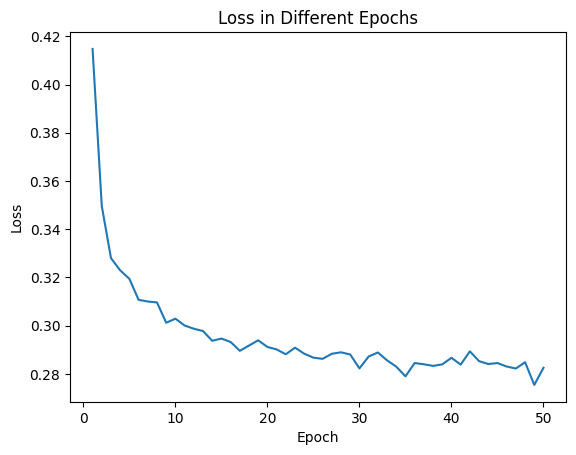

In [ ]:
plt.figure()
plt.plot(range(1,epochs+1), acc_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy in Different Epochs')

plt.figure()
plt.plot(range(1,epochs+1), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss in Different Epochs')

قسمت ب

In [ ]:
test_dataloader2 = DataLoader(train_dataset, batch_size=50000)
x_test_acc, y_test_acc = next(iter(test_dataloader2))
x_test_acc, y_test_acc = x_test_acc.to(device), y_test_acc.to(device)
model1.eval()
y_test_pred = model1(x_test_acc)
_ , test_pred = torch.max(y_test_pred, 1)
correct_counts = test_pred.eq(y_test_acc.view_as(test_pred))
train_acc = torch.mean(correct_counts.type(torch.FloatTensor))
print(f'Train Accuracy: {train_acc}')

x_test_acc, y_test_acc = next(iter(test_dataloader))
x_test_acc, y_test_acc = x_test_acc.to(device), y_test_acc.to(device)
model1.eval()
y_test_pred = model1(x_test_acc)
_ , test_pred = torch.max(y_test_pred, 1)
correct_counts = test_pred.eq(y_test_acc.view_as(test_pred))
test_acc = torch.mean(correct_counts.type(torch.FloatTensor))
print(f'Test Accuracy: {test_acc}')

Train Accuracy: 0.8925999999046326
Test Accuracy: 0.8845000267028809


In [ ]:
torch.save({
    'epoch': epochs,
    'model_state_dict': model1.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'train_acc': train_acc,
    'test_acc': test_acc,
}, 'model1.pth')

#Triplet Loss

قسمت آ

In [ ]:
def triplet_loss(y, margin):
    a = y[:,0:1000]
    p = y[:,1000:2000]
    n = y[:,2000:3000]
    d_a_p = torch.sum((a - p)**2, 1)
    d_a_n = torch.sum((a - n)**2, 1)

    triple = torch.max(d_a_p - d_a_n + margin, torch.Tensor([0.0]).to(device))
    return torch.mean(triple)

In [ ]:
def data_generator(x_train, y_train, batch_size):
    a=[]
    p=[]
    n=[]
    for i in range(batch_size):
        pos_neg = [0,1]
        x_train = torch.flatten(x_train , start_dim=1)
        positive_samples_mask = torch.randint(0, x[y == 1,:].size(0), (2,))
        negative_sample_mask = torch.randint(0, x[y == 0,:].size(0), (1,)).item()
        a.append(x_train[positive_samples_mask[0]].view(1,3,64,64))
        p.append(x_train[positive_samples_mask[1]].view(1,3,64,64))
        n.append(x_train[negative_sample_mask].view(1,3,64,64))
    anchor = torch.cat(a, dim=0)
    pos = torch.cat(p, dim=0)
    neg = torch.cat(n, dim=0)
    return anchor, pos, neg

قسمت ب

In [ ]:
transform = Compose([
    ToTensor(),
    CenterCrop(size=64)
])

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ['airplane', 'automobile']

def get_index(dataset, classes):
    indices = []
    for i, label in enumerate(dataset.targets):
        if dataset.classes[label] in classes:
            indices.append(i)
    return indices

train_indices =  get_index(full_train_dataset, classes)
test_indices =  get_index(full_test_dataset, classes)

train_dataset = torch.utils.data.Subset(full_train_dataset, train_indices)
test_dataset = torch.utils.data.Subset(full_test_dataset, test_indices)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=10000)

model2 = torchvision.models.alexnet(pretrained = True)
model2 = model2.to(device)

optimizer = torch.optim.Adam(model2.parameters(), lr=8e-6)
#-------------------------------
margin=0.35
fe_loss_list = []
epochs = 50
print('Training Feature Extractor ...')
for epoch in range(epochs):
    batch_loss = []
    model2.train()
    with tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch', leave=False) as epoch_progress:
        for t, (x, y) in enumerate(epoch_progress):
            x = x/torch.max(x)
            a, p, n = data_generator(x, y, batch_size)
            f_a = model2(a.to(device))
            f_p = model2(p.to(device))
            f_n = model2(n.to(device))
            outputs = torch.cat((f_a.to(device), f_p.to(device), f_n.to(device)), dim = 1)
            loss = triplet_loss(outputs, margin)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss.append(loss)
        fe_loss_list.append(float(sum(batch_loss)/len(batch_loss)))
print('Training Feature Extractor is Finished ...')
print('Training Classifier ...')

for param in model2.parameters():
    param.requires_grad = False

model2 = model2.to(device)
n_feaures = model2.classifier[6].in_features
model2.classifier[6] = nn.Linear(in_features = n_feaures, out_features = 2)
nn.init.xavier_normal_(model2.classifier[6].weight)
nn.init.zeros_(model2.classifier[6].bias)
model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model2.parameters(), lr = 1e-4)

epochs = 50
clf_loss_list = []
acc_list = []
for e in range(epochs):
    batch_loss = []
    batch_acc = []
    model2.train()
    with tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch', leave=False) as epoch_progress:
        for t, (x, y) in enumerate(epoch_progress):
            x, y = x.to(device), y.to(device)
            x = x/torch.max(x)
            y_pred = model2(x)
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss)
            _ , preds = torch.max(y_pred, 1)
            correct_counts = preds.eq(y.view_as(preds))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            batch_acc.append(acc)
        clf_loss_list.append(float(sum(batch_loss)/len(batch_loss)))
        acc_list.append(float(sum(batch_acc)/len(batch_acc)))
print('Training Classifier is Finished ...')

Files already downloaded and verified
Files already downloaded and verified
Training Feature Extractor ...


Training Feature Extractor is Finished ...
Training Classifier ...


Training Classifier is Finished ...


قسمت ج

Text(0.5, 1.0, 'Loss in Different Epochs (Triplet Loss) from epoch 20')

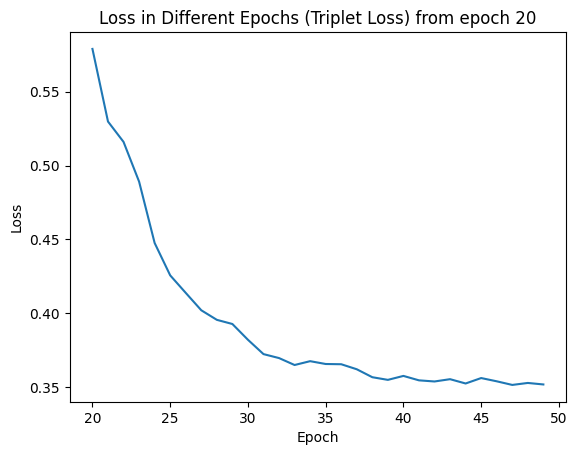

In [ ]:
plt.figure()
plt.plot(range(20,50), fe_loss_list[20:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss in Different Epochs (Triplet Loss) from epoch 20')

Text(0.5, 1.0, 'Loss in Different Epochs (Classification)')

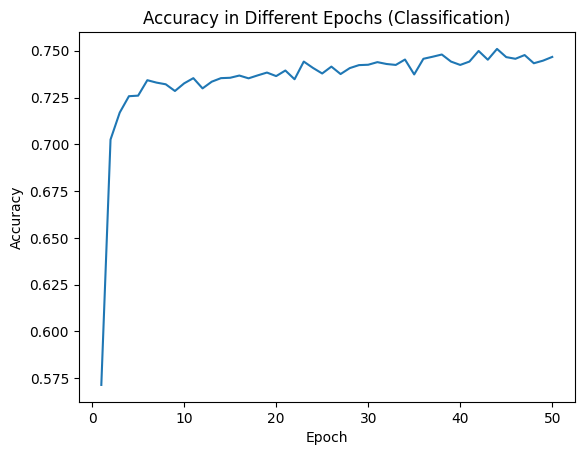

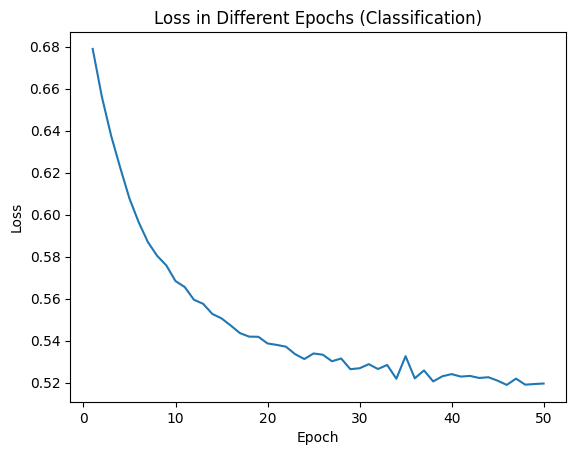

In [ ]:
plt.figure()
plt.plot(range(1,epochs+1), acc_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy in Different Epochs (Classification)')

plt.figure()
plt.plot(range(1,epochs+1), clf_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss in Different Epochs (Classification)')

قسمت د

In [ ]:
x_test_acc, y_test_acc = next(iter(test_dataloader))
x_test_acc, y_test_acc = x_test_acc.to(device), y_test_acc.to(device)
model2.eval()
y_test_pred = model2(x_test_acc)
_ , test_pred = torch.max(y_test_pred, 1)
correct_counts = test_pred.eq(y_test_acc.view_as(test_pred))
acc = torch.mean(correct_counts.type(torch.FloatTensor))
print(f'Test Accuracy: {acc}')

Test Accuracy: 0.781000018119812


دلیل اینکه دقت داده های تست نسبت به دقت داده های آموزشی در ایپاک های آخر نمودار بالاتر است، این است که در نمودار، میانگین تمام دقت های یک ایتریشن به عنوان دقت آن ایپاک محاسبه شده است.

In [ ]:
torch.save({
    'epoch': epochs,
    'model_state_dict': model2.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'test_acc': acc,
}, 'model2.pth')

## Triplet Loss and BCE


قسمت الف

In [ ]:
def triplet_loss(y, margin):
    a = y[:,0:2]
    p = y[:,2:4]
    n = y[:,4:6]
    d_a_p = torch.sum((a - p)**2, 1)
    d_a_n = torch.sum((a - n)**2, 1)

    triple = torch.max(d_a_p - d_a_n + margin, torch.Tensor([0.0]).to(device))
    return torch.mean(triple)

In [ ]:
def data_generator(x_train, y_train, batch_size):
    a=[]
    p=[]
    n=[]
    for i in range(batch_size):
        pos_neg = [0,1]
        x_train = torch.flatten(x_train , start_dim=1)
        positive_samples_mask = torch.randint(0, x[y == 1,:].size(0), (2,))
        negative_sample_mask = torch.randint(0, x[y == 0,:].size(0), (1,)).item()
        a.append(x_train[positive_samples_mask[0]].view(1,3,64,64))
        p.append(x_train[positive_samples_mask[1]].view(1,3,64,64))
        n.append(x_train[negative_sample_mask].view(1,3,64,64))
    anchor = torch.cat(a, dim=0)
    pos = torch.cat(p, dim=0)
    neg = torch.cat(n, dim=0)
    return anchor, pos, neg

In [ ]:
transform = Compose([
    ToTensor(),
    CenterCrop(size=64)
])

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ['airplane', 'automobile']

def get_index(dataset, classes):
    indices = []
    for i, label in enumerate(dataset.targets):
        if dataset.classes[label] in classes:
            indices.append(i)
    return indices

train_indices =  get_index(full_train_dataset, classes)
test_indices =  get_index(full_test_dataset, classes)

train_dataset = torch.utils.data.Subset(full_train_dataset, train_indices)
test_dataset = torch.utils.data.Subset(full_test_dataset, test_indices)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=10000)

model3 = torchvision.models.alexnet(pretrained = True)
n_feaures = model3.classifier[6].in_features
model3.classifier[6] = nn.Linear(in_features = n_feaures, out_features = 2)
nn.init.xavier_normal_(model3.classifier[6].weight)
nn.init.zeros_(model3.classifier[6].bias)
criterion = nn.CrossEntropyLoss()
model3=model3.to(device)

optimizer = torch.optim.Adam(model3.parameters(), lr=8e-6)
#-------------------------------
margin=0.35
clf_loss_list = []
acc_list = []
epochs = 25
for epoch in range(epochs):
    batch_loss = []
    batch_acc = []
    model3.train()
    with tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch', leave=False) as epoch_progress:
        for t, (x, y) in enumerate(epoch_progress):
            x = x/torch.max(x)
            a, p, n = data_generator(x, y, batch_size)
            f_a = model3(a.to(device))
            f_p = model3(p.to(device))
            f_n = model3(n.to(device))
            outputs = torch.cat((f_a.to(device), f_p.to(device), f_n.to(device)), dim = 1)
            y, outputs = y.to(device), outputs.to(device)
            x = x.to(device)
            y_pred = model3(x)
            loss = triplet_loss(outputs, margin) + criterion(y_pred.to(device), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss.append(loss)
            _ , preds = torch.max(y_pred, 1)
            correct_counts = preds.eq(y.view_as(preds))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            batch_acc.append(acc)
        clf_loss_list.append(float(sum(batch_loss)/len(batch_loss)))
        acc_list.append(float(sum(batch_acc)/len(batch_acc)))

Files already downloaded and verified
Files already downloaded and verified


قسمت ب

Text(0.5, 1.0, 'Loss in Different Epochs (Classification)')

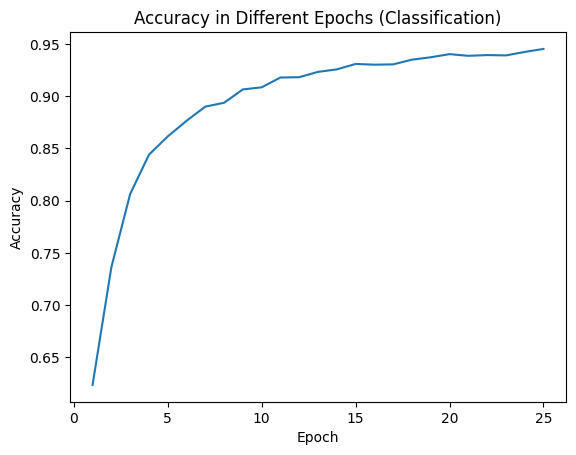

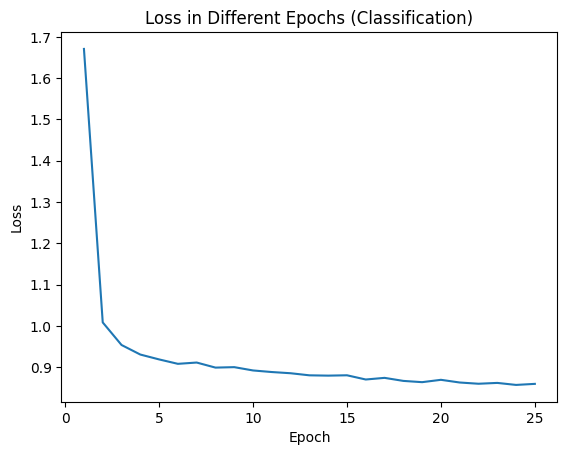

In [ ]:
plt.figure()
plt.plot(range(1,epochs+1), acc_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy in Different Epochs (Classification)')

plt.figure()
plt.plot(range(1,epochs+1), clf_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss in Different Epochs (Classification)')

قسمت ج

In [ ]:
test_dataloader2 = DataLoader(train_dataset, batch_size=50000)
x_test_acc, y_test_acc = next(iter(test_dataloader2))
x_test_acc, y_test_acc = x_test_acc.to(device), y_test_acc.to(device)
model3.eval()
y_test_pred = model3(x_test_acc)
_ , test_pred = torch.max(y_test_pred, 1)
correct_counts = test_pred.eq(y_test_acc.view_as(test_pred))
train_acc = torch.mean(correct_counts.type(torch.FloatTensor))
print(f'Train Accuracy: {train_acc}')

x_test_acc, y_test_acc = next(iter(test_dataloader))
x_test_acc, y_test_acc = x_test_acc.to(device), y_test_acc.to(device)
model3.eval()
y_test_pred = model3(x_test_acc)
_ , test_pred = torch.max(y_test_pred, 1)
correct_counts = test_pred.eq(y_test_acc.view_as(test_pred))
test_acc = torch.mean(correct_counts.type(torch.FloatTensor))
print(f'Test Accuracy: {test_acc}')

Train Accuracy: 0.9526000022888184
Test Accuracy: 0.9235000014305115


In [ ]:
torch.save({
    'epoch': epochs,
    'model_state_dict': model3.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'train_acc': train_acc,
    'test_acc': test_acc,
}, 'model3.pth')